In [1]:
import math
import copy
import paddle

def make_moons(n_samples = 1000, shuffle = True, noise = None):
    """
    生成带噪音的弯月形状数据
    输入：
        - n_samples：数据量大小，数据类型为int
        - shuffle：是否打乱数据，数据类型为bool
        - noise：以多大的程度增加噪声，数据类型为None或float，noise为None时表示不增加噪声
    输出：
        - X：特征数据，shape=[n_samples,2]
        - y：标签数据, shape=[n_samples]
    """
    n_samples_out = n_samples // 2 # //是一个算术运算符，表示整数除法，它可以返回商的整数部分（向下取整）
    n_samples_in  = n_samples - n_samples_out

    # 采集第1类数据，特征为(x,y)
    # 使用'paddle.linspace'在0到pi上均匀取n_samples_out个值
    # 使用'paddle.cos'计算上述取值的余弦值作为特征1，使用'paddle.sin'计算上述取值的正弦值作为特征2

    outer_circ_x = paddle.cos(paddle.linspace(0, math.pi, n_samples_out))
    outer_circ_y = paddle.sin(paddle.linspace(0, math.pi, n_samples_out))

    inner_circ_x = 1 - paddle.cos(paddle.linspace(0, math.pi, n_samples_in))
    inner_circ_y = 0.5 - paddle.sin(paddle.linspace(0, math.pi, n_samples_in))

    print('outer_circ_x.shape:',outer_circ_x.shape,'outer_cric_y.shape:',outer_circ_y.shape)
    print('inner_circ_x.shape:',inner_circ_x.shape,'inner_circ_y.shape:',inner_circ_y.shape)

    # 使用'paddle.concat'将两类数据的特征1和特征2分别延维度0拼接在一起，得到全部特征1和特征2
    # 使用'paddle.stack'将两类特征延维度1堆叠在一起
    X = paddle.stack(
        [paddle.concat([outer_circ_x,inner_circ_x]),
         paddle.concat([outer_circ_y, inner_circ_y])],
         axis=1
    )

    print('after concat shape:', paddle.concat([outer_circ_x,inner_circ_x]).shape)
    print(('X shape:', X.shape))

    # 使用'paddle. zeros'将第一类数据的标签全部设置为0
    # 使用'paddle. ones'将第一类数据的标签全部设置为1
    y = paddle.concat([paddle.zeros(shape=[n_samples_out]),paddle.ones(shape=[n_samples_in])])

    print('y shape:', y.shape)

    # 如果shuffle为True，将所有数据打乱

    if shuffle:
        # 使用'paddle.randperm'生成一个数值在0到X.shape[0]，随机排列的一维Tensor做索引值，用于打乱数据
        idx = paddle.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]

    # 如果noise不为None，则给特征值加入噪声
    
    if noise is not None:
        # 使用'paddle.normal'生成符合正态分布的随机Tensor作为噪声，并加到原始特征上
        X += paddle.normal(mean=0, std=noise, shape=X.shape)
    
    return X, y

outer_circ_x.shape: [500] outer_cric_y.shape: [500]
inner_circ_x.shape: [500] inner_circ_y.shape: [500]
after concat shape: [1000]
('X shape:', [1000, 2])
y shape: [1000]


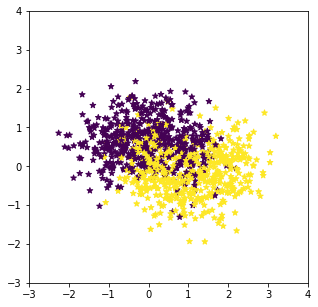

In [2]:
# 采样1000个样本
n_samples = 1000
X, y = make_moons(n_samples = n_samples, shuffle = True, noise = 0.5)

# 可视化生产的数据集，不同颜色代表不同类别
%matplotlib inline
# %matplotlib inline是IPython的魔法函数，可以在IPython编译器里直接使用，作用是内嵌画图，省略掉plt.show()这一步，直接显示图像
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(x=X[:,0].tolist(),y=X[:,1].tolist(), marker='*',c=y.tolist())
plt.xlim(-3,4)
plt.ylim(-3,4)
plt.savefig('linear-dataset-vis.pdf')
plt.show()

In [3]:
# 将1000条样本数据拆分成训练集、验证集和测试集，其中训练集640条、验证集160条、测试集200条
num_train = 640
num_dev = 160
num_test = 200

X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train+num_dev], y[num_train:num_train+num_dev]
X_test, y_test = X[num_train+num_dev:], y[num_train+num_dev:]

y_train = y_train.reshape([-1,1])
y_dev = y_dev.reshape([-1,1])
y_test = y_test.reshape([-1,1])

In [4]:
# 打印X_train和y_train的维度
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)

X_train shape: [640, 2] y_train shape: [640, 1]


In [5]:
# 打印一下前5个数据的标签

print(y_train[:5])

Tensor(shape=[5, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[1.],
        [0.],
        [0.],
        [0.],
        [1.]])


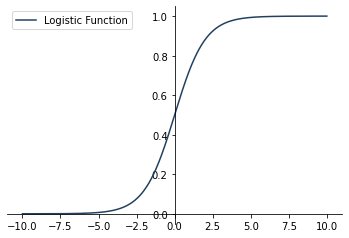

In [6]:
# 定义Logistic函数

def logistic(x):
    return 1 / (1 + paddle.exp(-x))

# 在[-10,10]的范围内生成一系列的输入值，用于绘制函数曲线
x = paddle.linspace(-10, 10, 10000)
plt.figure()
plt.plot(x.tolist(),logistic(x).tolist(), color="#223f60", label="Logistic Function")

# 设置坐标轴
ax = plt.gca()

# 取消右侧和上侧坐标轴
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

# 设置默认的x轴和y轴方向
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# 设置坐标原点为(0,0)
ax.spines['left'].set_position(('data',0))
ax.spines['bottom'].set_position(('data',0))

# 添加图例
plt.legend()
plt.savefig('linear-logistic.pdf')
plt.show()

In [7]:
import op

class Model_LR(op.Op):
    def __init__(self, input_dim):
        super(Model_LR, self).__init__()
        self.params = {}
        # 将线性层的权重参数全部初始化为0
        self.params['w'] = paddle.zeros(shape=[input_dim, 1])
        # self.params['w'] = paddle.normal(mean=0, std=0.01, shape=[input_dim, 1])
        # 将线性层的偏置参数初始化为0
        self.params['b'] = paddle.zeros(shape=[1])

    def __call__(self, inputs):
        return self.forward(inputs)
    
    def forward(self, inputs):
        """
        输入：
            - inputs: shape=[N,D], N是样本数量，D为特征维度
        输出：
            - outputs：预测标签为1的概率，shape=[N,1]
        """
        # 线性计算
        score = paddle.matmul(inputs,self.params['w']) + self.params['b']
        # logistic函数
        outputs = logistic(score)
        return outputs

In [8]:
# 固定随机种子，保持每次运行结果一致
paddle.seed(4)

# 随机生成3条长度为4的数据
inputs = paddle.randn(shape=[3,4])
print('Input is:', inputs)

# 实例化模型
model = Model_LR(4)
outputs = model(inputs)
print('Output is:', outputs)

#从输出结果看，模型最终的输出g(⋅)恒为0.5。这是由于采用全0初始化后，不论输入值的大小为多少，Logistic函数的输入值恒为0，因此输出恒为0.5。

Input is: Tensor(shape=[3, 4], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[-1.95052457, -0.06054528, -0.33960220, -0.31978330],
        [ 1.34362054,  0.99312043, -1.36814511, -0.18512607],
        [ 1.17020214, -0.66699255,  0.38559264, -0.68042481]])
Output is: Tensor(shape=[3, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.50000000],
        [0.50000000],
        [0.50000000]])


In [9]:
# 实现交叉熵损失函数

class BinaryCrossEntropyLoss(op.Op):
    def __init__(self):
        self.predicts = None
        self.labels = None 
        self.num = None
    
    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)
    
    def forward(self, predicts, labels):
        """
        输入：
            - predicts：预测值，shape=[N, 1]，N为样本数量
            - labels：真实标签，shape=[N, 1]
        输出：
            - 损失值：shape=[1]
        """
        self.predicts = predicts
        self.labels = labels
        self.num = self.predicts.shape[0]
        loss = -1. / self.num * (paddle.matmul(self.labels.t(), paddle.log(self.predicts)) + 
                                 paddle.matmul((1-self.labels.t()), paddle.log(1-self.predicts)))
        loss = paddle.squeeze(loss, axis=1)
        return loss
    
# 测试一下
# 生成一组长度为3，值为1的标签数据
labels = paddle.ones(shape=[3,1])

#  计算风险函数
bce_loss = BinaryCrossEntropyLoss()
print(bce_loss(outputs, labels))

Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.69314718])


In [10]:
# 梯度计算
class Model_LR(op.Op):
    def __init__(self,input_dim):
        super(Model_LR, self).__init__()

        # 存放线性层参数
        self.params = {}

        # 将线性层的权重参数全部初始化为0
        self.params['w'] = paddle.zeros(shape=[input_dim, 1])

        # self.params['w'] = paddle.normal(mean=0, std=0.01, shape=[input_dim, 1])
        # 将线性层的偏置参数初始化为0
        self.params['b'] = paddle.zeros(shape=[1])
        # 存放参数的梯度
        self.grads = {}
        self.X = None
        self.outputs =None
    
    def __call__(self, inputs):
        return self.forward(inputs)
    
    def forward(self, inputs):
        self.X = inputs
        # 线性计算
        score = paddle.matmul(inputs, self.params['w']) + self.params['b']
        # logistic函数
        self.outputs = logistic(score)
        return self.outputs
    
    def backward(self, labels):
        """
        输入：
            - labels：真实标签，shape=[N, 1]
        """
        N = labels.shape[0]
        # 计算偏导数
        self.grads['w'] = -1. / N * paddle.matmul(self.X.t(),(labels-self.outputs))
        self.grads['b'] = -1. / N * paddle.sum(labels-self.outputs)

In [11]:
from abc import abstractmethod

# 优化器基类
class Optimizer(object):
    def __init__(self, init_lr, model):
        """
        优化器类初始化
        """
        # 初始化学习率，用于参数更新的计算
        self.init_lr = init_lr
        # 指定优化器需要优化的模型
        self.model = model

    @abstractmethod
    def step(self):
        """
        定义每次迭代如何更新参数
        """
        pass

In [12]:
model.params.keys()

dict_keys(['w', 'b'])

In [13]:
class SimpeBatchGD(Optimizer):
    def __init__(self, init_lr, model):
        super(SimpeBatchGD, self).__init__(init_lr, model = model)
    
    def step(self):
        # 参数更新
        # 遍历所有参数，按照公式(3.8)和(3.9)更新参数
        if isinstance(self.model.params, dict):
            for key in self.model.params.keys():
                self.model.params[key] = self.model.params[key] - self.init_lr * self.model.grads[key]

In [14]:
def accuracy(preds, labels):
    """
    输入：
        - preds：预测值，二分类时，shape=[N, 1]，N为样本数量，多分类时，shape=[N, C]，C为类别数量
        - labels：真实标签，shape=[N, 1]
    输出：
        - 准确率：shape=[1]
    """
    # 判断是二分类任务还是多分类任务，preds.shape[1]=1时为二分类任务，preds.shape[1]>1时为多分类任务
    if preds.shape[1]  == 1:
        # 二分类时，判断每个概率值是否大于0.5，当大于0.5时，类别为1，否则类别为0
        # 使用'paddle.cast'将preds的数据类型转换为float32类型
        preds = paddle.cast((preds >= 0.5),dtype='float32')
    else:
        # 多分类时，使用'paddle.argmax'计算最大元素索引作为类别
        preds = paddle.argmax(preds, axis=1, dtype='int32')
    return paddle.mean(paddle.cast(paddle.equal(preds,labels),dtype='float32'))

# 假设模型的预测值为[[0.],[1.],[1.],[0.]]，真实类别为[[1.],[1.],[0.],[0.]]，计算准确率
preds = paddle.to_tensor([[0.],[1.],[1.],[0.]])
labels = paddle.to_tensor([[1.],[1.],[0.],[0.]])
print("accuracy is :", accuracy(preds, labels))

accuracy is : Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.50000000])


In [15]:
# 用RunnerV2类封装整个训练过程
class RunnerV2(object):
    def __init__(self, model, optimizer, metric, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.metric = metric
        self.loss_fn = loss_fn

        # 记录训练过程中的评价指标变化情况
        self.train_scores = []
        self.dev_scores = []

        # 记录训练过程中的损失函数变化情况
        self.train_loss = []
        self.dev_loss = []
        
    def train(self, train_set, dev_set, **kwargs):
        # 记录训练过程中的损失函数变化情况
        num_epochs = kwargs.get("num_epochs", 0)
        # 传入log打印频率，如果没有传入值则默认为100
        log_epochs = kwargs.get("log_epochs", 100)
        # 传入模型保存路径，如果没有传入值则默认为"best_model.pdparams"
        save_path = kwargs.get("save_path", "best_model.pdparams")
        # 梯度打印函数，如果没有传入则默认为"None"
        print_grads = kwargs.get("print_grads",None)
        # 记录全局最优指标
        best_scores = 0
        # 进行num_epochs轮训练
        for epoch in range(num_epochs):
            X, y = train_set
            # 获取模型预测
            logits = self.model(X)
            # 计算交叉熵损失
            trn_loss = self.loss_fn(logits, y).item()
            self.train_loss.append(trn_loss)

            # 计算评价指标
            trn_score = self.metric(logits, y).item()
            self.train_scores.append(trn_score)
            # 计算参数梯度
            self.model.backward(y)
            if print_grads is not None:
                # 打印每一层的梯度
                print_grads(self.model)
            # 更新模型参数
            self.optimizer.step()
            dev_score, dev_loss = self.evaluate(dev_set)

            # 如果当前指标为最优指标，保存该模型
            if dev_score > best_scores:
                self.save_model(save_path)
                print(f"best accuracy performance has been updated: {best_scores:5f} --> {dev_score:5f}")
                best_scores = dev_score
            if epoch % log_epochs == 0:
                print(f"[Train] epoch: {epoch}, loss: {trn_loss}, score: {trn_score}")
                print(f"[Dev] epoch: {epoch}, loss: {dev_loss}, score: {dev_score}")
        
    def evaluate(self, data_set):
        X, y = data_set
        # 计算模型输出
        logits = self.model(X)

        #计算损失函数
        loss = self.loss_fn(logits, y).item()
        self.dev_loss.append(loss)

        #计算评价指标
        score = self.metric(logits, y).item()
        self.dev_scores.append(score)
        return score, loss
    
    def predict(self, X):
        return self.model(X)
    
    def save_model(self, save_path):
        paddle.save(self.model.params, save_path)
    
    def load_model(self, model_path):
        self.model.params = paddle.load(model_path)

In [16]:
# 固定随机种子，保持每次运行结果一致
paddle.seed(102)

# 特征维度
input_dim = 2
# 学习率
lr = 0.1

# 实例化模型
model = Model_LR(input_dim=input_dim)

# 指定优化器
optimizer = SimpeBatchGD(init_lr=lr, model=model)

# 指定损失函数
loss_fn = BinaryCrossEntropyLoss()

# 指定评价方式
metric = accuracy

# 实例化RunnerV2类，并传入训练配置
runner = RunnerV2(model, optimizer, metric, loss_fn)

runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=500, log_epochs = 50, save_path = 'best_model.pdparams')


best accuracy performance has been updated: 0.000000 --> 0.762500
[Train] epoch: 0, loss: 0.6931471824645996, score: 0.4937499761581421
[Dev] epoch: 0, loss: 0.6836539506912231, score: 0.762499988079071
best accuracy performance has been updated: 0.762500 --> 0.768750
best accuracy performance has been updated: 0.768750 --> 0.775000
best accuracy performance has been updated: 0.775000 --> 0.781250
[Train] epoch: 50, loss: 0.5000917315483093, score: 0.7875000238418579
[Dev] epoch: 50, loss: 0.5026491284370422, score: 0.7749999761581421
[Train] epoch: 100, loss: 0.46491146087646484, score: 0.7921874523162842
[Dev] epoch: 100, loss: 0.4635434150695801, score: 0.7749999761581421
[Train] epoch: 150, loss: 0.4527616500854492, score: 0.7999999523162842
[Dev] epoch: 150, loss: 0.44772598147392273, score: 0.7749999761581421
[Train] epoch: 200, loss: 0.44731244444847107, score: 0.8031250238418579
[Dev] epoch: 200, loss: 0.4395705759525299, score: 0.7749999761581421
best accuracy performance has 

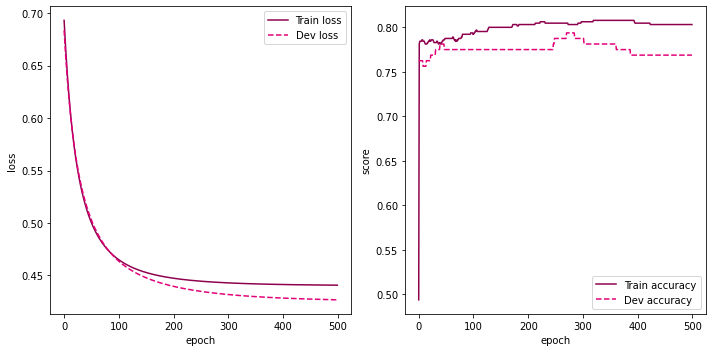

In [17]:
# 可视化观察训练集与验证集的指标变化情况
def plot(runner, fig_name):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    epochs = [i for i in range(len(runner.train_scores))]

    # 绘制训练损失变化曲线
    plt.plot(epochs, runner.train_loss, color='#8E004D', label="Train loss")

    # 绘制评价损失变化曲线
    plt.plot(epochs, runner.dev_loss, color='#E20079', linestyle='--', label="Dev loss")

    # 绘制坐标轴和图例
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc = 'upper right')
    plt.subplot(1,2,2)
    # 绘制训练准确率变化曲线
    plt.plot(epochs, runner.train_scores, color='#8E004D', label="Train accuracy")
    plt.plot(epochs, runner.dev_scores, color='#E20079', linestyle='--', label="Dev accuracy")
    # 绘制坐标轴和图例
    plt.ylabel("score")
    plt.xlabel("epoch")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(fig_name)
    plt.show()

plot(runner,fig_name='linear-acc.pdf')



In [18]:
# 模型评价
score, loss  = runner.evaluate([X_test,y_test])
print("[Test] score/loss: {:4f}/{:4f}".format(score,loss))

[Test] score/loss: 0.820000/0.386156


In [19]:
def decision_boundary(w, b, x1):
    w1, w2 = w
    x2 = (-w1 * x1 -b) / w2
    return x

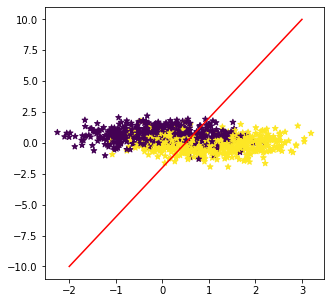

In [20]:
plt.figure(figsize=(5,5))
# 绘制原始数据
plt.scatter(X[:, 0].tolist(), X[:, 1].tolist(), marker='*', c=y.tolist())

w = model.params['w']
b = model.params['b']
x1 = paddle.linspace(-2, 3, 10000)
x2 = decision_boundary(w, b, x1)
# 绘制决策边界
plt.plot(x1.tolist(), x2.tolist(), color="red")
plt.show()

In [21]:
# 基于Softmax回归的多分类任务

# 数据集生成
import numpy as np

def make_multiclass_classification(n_samples=100, n_features=2, n_classes=3, shuffle = True, noise=0.1):
    """
    生成带噪音的多类别数据
    输入：
        - n_samples：数据量大小，数据类型为int
        - n_features：特征数量，数据类型为int
        - shuffle：是否打乱数据，数据类型为bool
        - noise：以多大的程度增加噪声，数据类型为None或float，noise为None时表示不增加噪声
    输出：
        - X：特征数据，shape=[n_samples,2]
        - y：标签数据, shape=[n_samples,1]
    """
    # 计算每个类别的样本数量
    n_samples_per_class = [int(n_samples/n_classes) for k in range(n_classes)]
    for i in range(n_samples -sum(n_samples_per_class)):
        n_samples_per_class[i % n_classes] +=1

    # 将特征和标签初始化为0
    X = paddle.zeros([n_samples, n_features])
    y = paddle.zeros([n_samples], dtype='int32')

    # 随机生成3个簇中心作为类别中心
    centroids = paddle.randperm(2** n_features)[: n_classes]
    # unpackbits函数可以把整数转化成2进制数
    centroids_bin = np.unpackbits(centroids.numpy().astype('uint8')).reshape((-1, 8))[:, -n_features:]
    centroids = paddle.to_tensor(centroids_bin,dtype='float32')
    # 控制簇中心的分离程度
    centroids = 1.5 * centroids -1
    # 随机生成特征值
    X[:,:n_features] = paddle.randn(shape=[n_samples, n_features])

    stop = 0
    # 将每个类的特征值控制在簇中心附近
    for k, centroid in enumerate(centroids):
        start, stop = stop, stop + n_samples_per_class[k]
        # 指定标签值
        y[start:stop] = k%n_classes
        X_k = X[start:stop, :n_features]
        # 控制每个类别特征值的分散程度
        A = 2* paddle.rand(shape=[n_features, n_features]) - 1
        X_k[...] = paddle.matmul(X_k, A)
        X_k += centroid
        X[start:stop, :n_features] = X_k

    # 如果noise不为None，则给特征加入噪声
    if noise > 0.0:
        # 生成noise掩膜，用来指定给那些样本加入噪声
        noise_mask = paddle.rand([n_samples]) < noise
        for i in range(len(noise_mask)):
            if noise_mask[i]:
                # 给加噪声的样本随机赋标签值
                y[i] = paddle.randint(n_classes, shape=[1]).astype('int32')
    
    # 如果shuffle为True，将所有数据打乱
    if shuffle:
        idx = paddle.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]

    return X,y
    
        

In [22]:
# 数据生成测试
n_samples=100
n_features=2
n_classes=3

n_samples_per_class = [int(n_samples/n_classes) for k in range(n_classes)]
for i in range(n_samples -sum(n_samples_per_class)):
    n_samples_per_class[i % n_classes] +=1

# 将特征和标签初始化为0
X = paddle.zeros([n_samples, n_features])
y = paddle.zeros([n_samples], dtype='int32')

# 随机生成3个簇中心作为类别中心
centroids = paddle.randperm(2** n_features)[: n_classes]
print(centroids)

centroids_bin = np.unpackbits(centroids.numpy().astype('uint8')).reshape((-1, 8))
c = centroids_bin[:, -n_features:]
print(centroids_bin)
print(c)
centroids.numpy().astype('uint8')
print(paddle.to_tensor(c,dtype='float32'))
c = 1.5 * c -1
print(c)
X[:, :n_features] = paddle.randn(shape=[n_samples, n_features])
# print(X[:, :n_features])

stop = 0
for k, centroid in enumerate(centroids):
    start, stop = stop, stop + n_samples_per_class[k]
    # print(n_samples_per_class[k])
    # 指定标签值
    y[start:stop] = k % n_classes
    print(y[start:stop])
    X_k = X[start:stop, :n_features]
    # 控制每个类别特征值的分散程度
    A = 2 * paddle.rand(shape=[n_features, n_features]) - 1
    print(A)
    X_k[...] = paddle.matmul(X_k, A)
    # print(X_k[...])
    X_k += centroid
    # print(X_k[...])
    X[start:stop, :n_features] = X_k

noise =0.2
noise_mask = paddle.rand([n_samples]) < noise
print(noise_mask)

Tensor(shape=[3], dtype=int64, place=Place(gpu:0), stop_gradient=True,
       [2, 0, 1])
[[0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
[[1 0]
 [0 0]
 [0 1]]
Tensor(shape=[3, 2], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[1., 0.],
        [0., 0.],
        [0., 1.]])
[[ 0.5 -1. ]
 [-1.  -1. ]
 [-1.   0.5]]
Tensor(shape=[34], dtype=int32, place=Place(gpu:0), stop_gradient=True,
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Tensor(shape=[2, 2], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[-0.30428541,  0.13167429],
        [-0.22429347,  0.21246767]])
Tensor(shape=[33], dtype=int32, place=Place(gpu:0), stop_gradient=True,
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1])
Tensor(shape=[2, 2], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[-0.75975895,  0.75318849],
        [-0.54201674

d:\Anaconda3\lib\site-packages\paddle\fluid\dygraph\math_op_patch.py:277: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.int64, the right dtype will convert to paddle.float32
  .format(lhs_dtype, rhs_dtype, lhs_dtype))


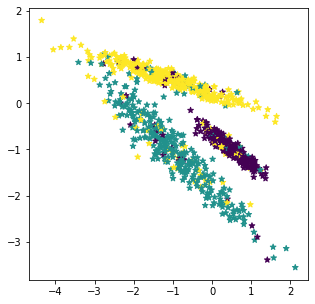

In [23]:
# 固定随机种子，保持每次运行结果一致
paddle.seed(102)

# 采样1000个样本
n_samples =1000
X, y = make_multiclass_classification(n_samples=n_samples, n_features=2, n_classes=3, noise=0.2)

# 可视化生产的数据集，不同颜色代表不同类别
plt.figure(figsize=(5,5))
plt.scatter(x=X[:,0].tolist(), y=X[:, 1].tolist(), marker='*', c=y.tolist())
plt.savefig('linear-dataset-vis2.pdf')
plt.show()



In [24]:
num_train = 640
num_dev = 160
num_test = 200

X_train, y_train = X[:num_train], y[: num_train]
X_dev, y_dev = X[num_train:num_train+num_dev], y[num_train: num_train+num_dev]
X_test, y_test = X[num_train+num_dev:], y[num_train+num_dev:]

# 打印X_train和y_train的维度
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)

# 打印前5个数据的标签
print(y_train[:5])

X_train shape: [640, 2] y_train shape: [640]
Tensor(shape=[5], dtype=int32, place=Place(gpu:0), stop_gradient=True,
       [0, 0, 1, 1, 0])


In [28]:
# 模型构建

# X为张量-tensor
def softmax(X):
    """
    输入：
        - X：shape=[N, C]，N为向量数量，C为向量维度
    """
    x_max = paddle.max(X, axis=1, keepdim=True)
    x_exp = paddle.exp(X-x_max)
    partition = paddle.sum(x_exp, axis=1, keepdim=True)
    return x_exp / partition

# 观察softmax的计算方式
X = paddle.to_tensor([[0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4]])
predict = softmax(X)
print(predict)    


Tensor(shape=[2, 4], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.21383820, 0.23632778, 0.26118261, 0.28865141],
        [0.03205860, 0.08714432, 0.23688284, 0.64391422]])


In [30]:
class model_SR(op.Op):
    def __init__(self, input_dim, output_dim):
        super(model_SR, self).__init__()
        self.params = {}

        # 将线性层的权重参数全部初始化为0
        self.params['W'] = paddle.zeros(shape=[input_dim, output_dim])
        # self.params['W'] = paddle.normal(mean=0, std=0.01, shape=[input_dim, output_dim])
        
        # 将线性层的偏置参数初始化为0
        self.params['b'] = paddle.zeros(shape=[output_dim])

        self.outputs = None

    def __call__(self, inputs):
        return self.forward(inputs)
    
    def forward(self, inputs):
        """
        输入：
            - inputs: shape=[N,D], N是样本数量，D是特征维度
        输出：
            - outputs：预测值，shape=[N,C]，C是类别数
        """
        # 线性计算
        score = paddle.matmul(inputs, self.params['W']) + self.params['b']
        # Softmax函数
        self.outputs = softmax(score)
        return self.outputs
    
# 随机生成1条长度为4的数据
inputs = paddle.randn(shape=[1,4])
print('Input is:', inputs)
# 实例化模型，这里令输入长度为4，输出类别数为3
model = model_SR(input_dim=4, output_dim=3)
outputs = model(inputs)
print('Outputs is:', outputs)



Input is: Tensor(shape=[1, 4], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[ 1.52324808,  0.26465878, -0.12106060, -1.08118045]])
Outputs is: Tensor(shape=[1, 3], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.33333334, 0.33333334, 0.33333334]])


In [35]:
class MultiCrossEntropyLoss(op.Op):
    def __init__(self):
        self.predicts = None
        self.label = None
        self.num = None

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)
    
    def forward(self, predicts, labels):
        """
        输入：
            - predicts：预测值，shape=[N, 1]，N为样本数量
            - labels：真实标签，shape=[N, 1]
        输出：
            - 损失值：shape=[1]
        """
        self.predicts = predicts
        self.label = labels
        self.num = self.predicts.shape[0]
        loss = 0
        for i in range(0, self.num):
            index = self.label[i]
            loss -= paddle.log(self.predicts[i][index])
        return loss/self.num
    
# 测试
# 假设真实标签为第1类
labels = paddle.to_tensor([0])
# 计算风险函数
mce_loss = MultiCrossEntropyLoss()
print(mce_loss(outputs, labels))



Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [1.09861231])


In [36]:
# 模型优化
class model_SR(op.Op):
    def __init__(self, input_dim, output_dim):
        super(model_SR, self).__init__()
        self.params = {}
        # 将线性层的权重参数全部初始化为0
        self.params['W'] = paddle.zeros(shape=[input_dim, output_dim])
        # self.params['W'] = paddle.normal(mean=0, std=0.01, shape=[input_dim, output_dim])
        # 将线性层的偏置参数初始化为0
        self.params['b'] = paddle.zeros(shape=[output_dim])
        # 存放参数的梯度
        self.grads = {}
        self.X = None
        self.outputs = None
        self.output_dim = output_dim
    
    def __call__(self, inputs):
        return self.forward(inputs)
    
    def forward(self, inputs):
        self.X = inputs
        
        # 线性计算
        score = paddle.matmul(self.X, self.params['W']) + self.params['b']
        # Softmax函数
        self.outputs = softmax(score)

        return self.outputs
    
    def backward(self, labels):
        """
        输入：
            - labels：真实标签，shape=[N, 1]，其中N为样本数量
        """
        # 计算偏导数
        N = labels.shape[0]
        labels = paddle.nn.functional.one_hot(labels, self.output_dim)

        self.grads['W'] = -1. / N * paddle.matmul(self.X.t(), (labels-self.outputs))
        self.grads['b'] = -1. / N * paddle.matmul(paddle.ones(shape=[N]), (labels-self.outputs))
        # self.grads['b'] = -1. / N * paddle.sum(labels-self.outputs)

best accuracy performance has been updated: 0.000000 --> 0.712500
[Train] epoch: 0, loss: 1.098615050315857, score: 0.35625001788139343
[Dev] epoch: 0, loss: 1.07489812374115, score: 0.7125000357627869
best accuracy performance has been updated: 0.712500 --> 0.718750
best accuracy performance has been updated: 0.718750 --> 0.731250
best accuracy performance has been updated: 0.731250 --> 0.737500
best accuracy performance has been updated: 0.737500 --> 0.743750
best accuracy performance has been updated: 0.743750 --> 0.750000
best accuracy performance has been updated: 0.750000 --> 0.756250
best accuracy performance has been updated: 0.756250 --> 0.762500
best accuracy performance has been updated: 0.762500 --> 0.768750
best accuracy performance has been updated: 0.768750 --> 0.775000
best accuracy performance has been updated: 0.775000 --> 0.781250
best accuracy performance has been updated: 0.781250 --> 0.787500
[Train] epoch: 100, loss: 0.7335196733474731, score: 0.7843749523162842


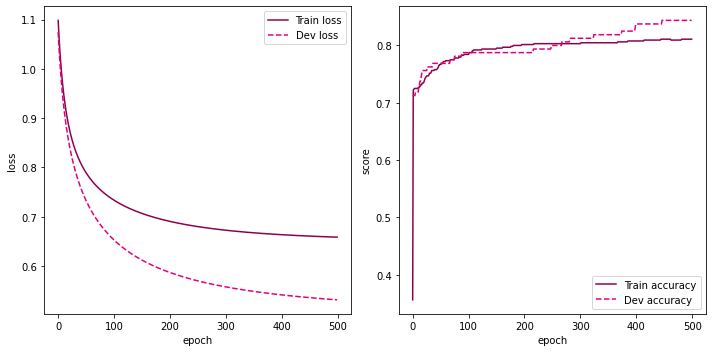

In [38]:
# 固定随机种子，保持每次运行结果一致
paddle.seed(102)

# 特征维度
input_dim = 2
# 类别数
output_dim = 3
# 学习率
lr = 0.1

# 实例化模型
model = model_SR(input_dim=input_dim, output_dim=output_dim)

# 指定优化器
optimizer = SimpeBatchGD(init_lr=lr, model=model)

# 指定损失函数
loss_fn = MultiCrossEntropyLoss()

#指定评价方式
metric = accuracy 

# 实例化RunnerV2类
runner = RunnerV2(model, optimizer, metric, loss_fn)

# 模型训练
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs = 500, log_epoch = 50, eval_epochs = 1, save_path ="best_model.pdparams")

# 可视化观察训练集与验证集的准确率变化情况

plot(runner, fig_name='linear-acc2.pdf')

In [39]:
# 模型评价
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.8400/0.5562


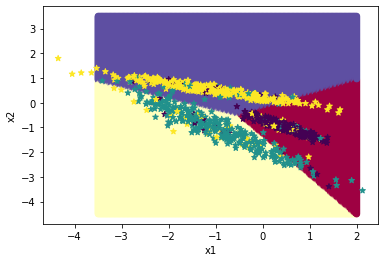

In [59]:
# 均匀生成40000个数据点
x1, x2 = paddle.meshgrid(paddle.linspace(-3.5, 2, 200), paddle.linspace(-4.5, 3.5, 200))
# print(x1, x2) # meshgrid 函数用来生成网格矩阵

x = paddle.stack([paddle.flatten(x1), paddle.flatten(x2)], axis=1)
# flatten()是对多维数据的降维函数
# print(paddle.flatten(x1))
# print(x)

# 预测对应类别
y = runner.predict(x)
y = paddle.argmax(y, axis=1)

# 绘制类别区域
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(x[:,0].tolist(),x[:,1].tolist(), c = y.tolist(), cmap=plt.cm.Spectral)

paddle.seed(102)
n_samples = 1000
X, y = make_multiclass_classification(n_samples=n_samples, n_features=2, n_classes = 3, noise = 0.2)
plt.scatter(X[:,0].tolist(), X[:,1].tolist(), marker='*', c=y.tolist())